In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#for timestamp column
from datetime import date

# matplotlib and seaborn for plotting
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# hide warnings
import warnings
def ignore_warn(*args, **kwargs): pass
warnings.warn = ignore_warn

# machine learining
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Statistics
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Mathematics
from math import log

# Pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns',500 )
pd.set_option('display.max_rows',100 )
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
# pd.reset_option("display.max_rows")

# Save and Load Machine Learning Models
import pickle

In [3]:
# some auxiliary functions
def detect_outliers(df,n,features):
        """
        Takes a dataframe df of features and returns a list of the indices
        corresponding to the observations containing more than n outliers according
        to the Tukey method.
        """
        outlier_indices = []
        # iterate over features(columns)
        for col in features:
            # 1st quartile (25%)
            Q1 = np.percentile(df[col], 25)
            # 3rd quartile (75%)
            Q3 = np.percentile(df[col],75)
            # Interquartile range (IQR)
            IQR = Q3 - Q1

            # outlier step
            outlier_step = 1.5 * IQR

            # Determine a list of indices of outliers for feature col
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

            # append the found outlier indices for col to the list of outlier indices 
            outlier_indices.extend(outlier_list_col)

        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)        
        multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
        return multiple_outliers
    
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
def plot_feature_importances(df):
        """
        Plot importances returned by a model. This can work with any measure of
        feature importance provided that higher importance is better. 

        Args:
            df (dataframe): feature importances. Must have the features in a column
            called `features` and the importances in a column called `importance

        Returns:
            shows a plot of the 15 most importance features

            df (dataframe): feature importances sorted by importance (highest to lowest) 
            with a column for normalized importance
            """

        # Sort features according to importance
        df = df.sort_values('importance', ascending = False).reset_index()

        # Normalize the feature importances to add up to one
        df['importance_normalized'] = df['importance'] / df['importance'].sum()

        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(df.index[:15]))))
        ax.set_yticklabels(df['feature'].head(15))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()
        return df


In [4]:
def load_data(csv_name, load_from_disk = False):
    if load_from_disk:
        return pd.read_pickle(csv_name + '.pkl')
    
    data = pd.read_csv(csv_name + '.csv')
    data.to_pickle(csv_name + ".pkl")
    return data

In [5]:
class descriptive_statistics:
    def __init__(self, df, label):
        self.df = df
        self.label = label
        
    def corrmat(self):
        return self.df.corr()
        
    def most_correlated_features(self, print_heatmap = True ,tol=0.5):
        corrmat = self.df.corr()
        top_corr_features = corrmat.index[abs(corrmat[self.label]) > tol]
        if print_heatmap:
            plt.figure(figsize=(10,10))
            sns.heatmap(self.df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
        return top_corr_features.values
    
#     def graph_between_most_correlated_features(self, tol=0.5):
#         sns.set()
#         corrmat = self.df.corr()
#         top_corr_features = corrmat.index[abs(corrmat[self.label]) > tol]
# #         corrmat.index[abs(corrmat[self.label]) > tol]
#         cols = top_corr_features.values
#         sns.pairplot(self[cols], size = 2.5)
#         plt.show();
    
    def mean(self, feature):
        return np.mean(self.df[feature])
    
    def median(self, feature):
        return np.median(self.df[feature])
    
    def standard_deviation(self, feature):
        return np.std(self.df[feature])

In [6]:
def data_preprocessing(data, is_train_dataset = False):
    print('---------------------------------------')
    print('Starting preprocessing')
    print('---------------------------------------')
    print('checking the volume of missing values')
    print('---------------------------------------')
    missing_values_table(data)
    print('---------------------------------------')
    
    data.drop("Id", axis = 1, inplace = True)
    if is_train_dataset:
        print('Delete outliers for training dataset')
        print('---------------------------------------')
        ddxk = descriptive_statistics(df=data,label='SalePrice' )
        Outliers_to_drop = detect_outliers(data,2, ddxk.most_correlated_features(print_heatmap = False))
        data = data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
    
    data["PoolQC"] = data["PoolQC"].fillna("None")
    data["MiscFeature"] = data["MiscFeature"].fillna("None")
    data["Alley"] = data["Alley"].fillna("None")
    data["Fence"] = data["Fence"].fillna("None")
    data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        data[col] = data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        data[col] = data[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        data[col] = data[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        data[col] = data[col].fillna('None')
    data["MasVnrType"] = data["MasVnrType"].fillna("None")
    data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
    data = data.drop(['Utilities'], axis=1)
    data["Functional"] = data["Functional"].fillna("Typ")
    data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
    data['MSSubClass'] = data['MSSubClass'].fillna("None")
    
    #MSSubClass=The building class
    data['MSSubClass'] = data['MSSubClass'].apply(str)

    #Changing OverallCond into a categorical variable
    data['OverallCond'] = data['OverallCond'].astype(str)


    #Year and month sold are transformed into categorical features.
    data['YrSold'] = data['YrSold'].astype(str)
    data['MoSold'] = data['MoSold'].astype(str)

    from sklearn.preprocessing import LabelEncoder
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold')
    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(data[c].values)) 
        data[c] = lbl.transform(list(data[c].values))
    
    # Adding total sqfootage feature 
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    
    data = pd.get_dummies(data)

    # shape        
    print('Shape data: {}'.format(data.shape))
    print('---------------------------------------')
    print('The preprocessing stage is already done')
    print('---------------------------------------')
    print('checking the volume of missing values again')
    print('---------------------------------------')
    missing_values_table(data)    
    print('---------------------------------------')
    return data
    

In [7]:
# for training data
def label_distribution(data, label):
    sns.distplot(data[label] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data[label])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(label + ' distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data[label], plot=plt)
    plt.show()

In [8]:
def log_transformation(data, label):
    #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
    data[label] = np.log1p(data[label])

    #Check the new distribution 
    sns.distplot(data[label] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data[label])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(label + ' distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data[label], plot=plt)
    plt.show()

In [9]:
#Validation function
n_folds = 5

def rmsle_cv(model, X, Y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [10]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1) 

In [11]:
# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
   
#     # We again fit the data on clones of the original models
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
#         # Train cloned base models then create out-of-fold predictions
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # Now train the cloned  meta-model using the out-of-fold predictions as new feature
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
   
#     #Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

In [13]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [22]:
def main(args, load_from_disk=False):
    train_data = load_data(csv_name='train', load_from_disk=False)
    print('********** Preprocessing Phase **********')
    train_data = data_preprocessing(data=train_data,is_train_dataset=True)
    print('********** Label Distribution **********')
    label_distribution(train_data, label='SalePrice')
    print('********** Log Transformation **********')
    log_transformation(data=train_data, label='SalePrice')
    
    X = train_data.drop(columns=["SalePrice"])
    Y = train_data["SalePrice"]
    
    test_size = 0.33
    seed = 7
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    # Fit the model on 33%
    
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    GBoost = GradientBoostingRegressor()
    model_xgb = xgb.XGBRegressor()
    model_lgb = lgb.LGBMRegressor(objective='regression')
    
    print("\nLasso score: {:.4f} ({:.4f})\n".format(rmsle_cv(lasso, X_train, Y_train).mean(), rmsle_cv(lasso, X_train, Y_train).std()))
    print("ElasticNet score: {:.4f} ({:.4f})\n".format(rmsle_cv(ENet, X_train, Y_train).mean(), rmsle_cv( ENet , X_train, Y_train).std()))
    print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(rmsle_cv(KRR, X_train, Y_train).mean(), rmsle_cv( KRR , X_train, Y_train).std()))
    print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(rmsle_cv(GBoost, X_train, Y_train).mean(), rmsle_cv( GBoost , X_train, Y_train).std()))
    print("XGboost score: {:.4f} ({:.4f})\n".format(rmsle_cv(model_xgb, X_train, Y_train).mean(), rmsle_cv( model_xgb , X_train, Y_train).std()))
    print("LGBM score: {:.4f} ({:.4f})\n" .format(rmsle_cv(model_lgb, X_train, Y_train).mean(), rmsle_cv( model_lgb , X_train, Y_train).std()))

    averaged_models = AveragingModels(models = (lasso , ENet , GBoost, model_xgb, model_lgb))
    print("Averaged base models score: {:.4f} ({:.4f})\n".format(rmsle_cv(averaged_models, X_train, Y_train).mean(), rmsle_cv(averaged_models, X_train, Y_train).std()))
    
    
#     test_data = load_data(csv_name='test', load_from_disk=False)
#     test_data = data_preprocessing(data=test_data,is_train_dataset=False)
#     test_data.head()
#     missing_cols = set(X.columns ) - set(test_data.columns )
#     # Add a missing column in test set with default value equal to 0
#     for c in missing_cols:
#         test_data[c] = 0
#     # Ensure the order of column in the test set is in the same order than in train set
#     test_data = X[X.columns]
# #     y_pred = boost.predict(test_X)[0]
# #     print("predicted duration is %f days" % y_pred)
# #     print("actual duration is %f days" % test_Y)
    
#     print("--------------------------------")
#     print("--------------------------------")
#     print("--------------------------------")
#     print(cross_val_score(averaged_models, X_train, Y_train, cv=5, verbose=True))
    
    
    averaged_models.fit(X_train, Y_train)
    averaged_train_pred = averaged_models.predict(X_train)
    y_pred = np.expm1(averaged_models.predict(X_test))[0]
    print("\nMy final model is averaged model\n")
    print("RMSE : {:.4f}\n".format(rmsle(Y_train, averaged_train_pred)))
    

    print("training has been completed succesfully !!!!")
    print("--------------------------------------------")
    
#     print("predicted value is %f " % y_pred)
#     print("actual duration is %f days" % Y_test)
    
    
#     filename = 'finalized_model.sav'
#     pickle.dump(averaged_models, open(filename, 'wb'))
    
    
#     # some time later...

#     # load the model from disk
#     loaded_model = pickle.load(open(filename, 'rb'))
#     result = loaded_model.score(X_test, Y_test)
#     print("Results on testing data set !!!\n")
#     print("Score on test data set : {:.4f}".format(result))


In [15]:
#     train_data = load_data(csv_name='train', load_from_disk=False)
#     print('********** Preprocessing Phase **********')
#     train_data = data_preprocessing(data=train_data,is_train_dataset=True)
#     print('********** Label Distribution **********')
#     label_distribution(train_data, label='SalePrice')
#     print('********** Log Transformation **********')
#     log_transformation(data=train_data, label='SalePrice')
    
#     X = train_data.drop(columns=["SalePrice"])
#     Y = train_data["SalePrice"]

In [16]:
#     test_data = load_data(csv_name='test', load_from_disk=False)
#     test_data = data_preprocessing(data=test_data,is_train_dataset=False)
#     test_data.head()
#     missing_cols = set(X.columns ) - set(test_data.columns )
# #     print(missing_cols)
#     # Add a missing column in test set with default value equal to 0
#     for c in missing_cols:
#         test_data[c] = 0
#     # Ensure the order of column in the test set is in the same order than in train set
#     test_data = X[X.columns]

********** Preprocessing Phase **********
---------------------------------------
Starting preprocessing
---------------------------------------
checking the volume of missing values
---------------------------------------
Your selected dataframe has 81 columns.
There are 19 columns that have missing values.
---------------------------------------
Delete outliers for training dataset
---------------------------------------
Shape data: (1440, 220)
---------------------------------------
The preprocessing stage is already done
---------------------------------------
checking the volume of missing values again
---------------------------------------
Your selected dataframe has 220 columns.
There are 0 columns that have missing values.
---------------------------------------
********** Label Distribution **********

 mu = 177012.20 and sigma = 70287.86



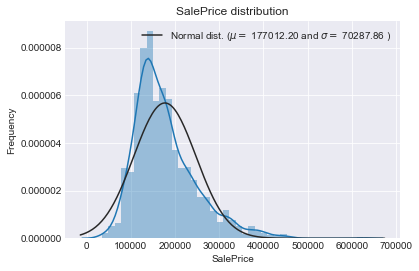

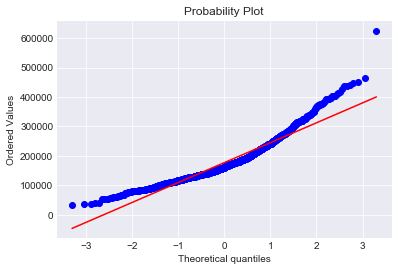

********** Log Transformation **********

 mu = 12.01 and sigma = 0.38



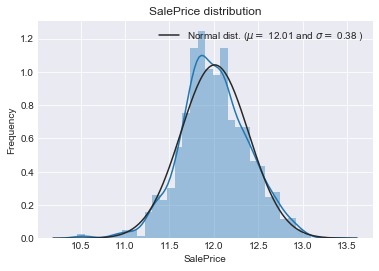

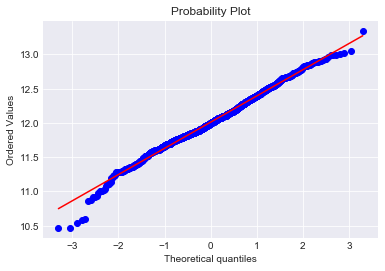


Lasso score: 0.1189 (0.0188)

ElasticNet score: 0.1190 (0.0184)

Kernel Ridge score: 1.5437 (1.5019)

Gradient Boosting score: 0.1291 (0.0215)

XGboost score: 0.1298 (0.0234)

LGBM score: 0.1296 (0.0242)

Averaged base models score: 0.1164 (0.0228)


My final model is averaged model

RMSE : 0.0727

training has been completed succesfully !!!!
--------------------------------------------


In [23]:
main(args=None, load_from_disk=True)
